In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM,GRU, Embedding, Dense, Concatenate
from keras.models import Model

print(os.listdir("."))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
drive.mount('/content/drive')
# Any results you write to the current directory are saved as output.

['.config', 'nmt_weights1.h5', 'X_train.pkl', 'dot_img_file.jpeg', 'X_test.pkl', 'drive', 'sample_data']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
#lines=pd.read_csv("./Hindi_English_Truncated_Corpus.csv",encoding='utf-8')
fields = ['english','hindi','english_gloss','hindi_gloss']
# Mounting drive
# This will require authentication : Follow the steps as guided


lines=pd.read_csv("/content/drive/My Drive/df_synset.csv",encoding='utf-8', usecols=fields)

In [3]:
lines.head(20)

,english,english_gloss,hindi,hindi_gloss
0,['suiting'],a fabric used for suits,['सूटिंग'],सूट बनवाने का कपड़ा
1,['penalty'],(games) a handicap or disadvantage that is imposed on a competitor (or a team) for an infraction of the rules of the game,['पेनाल्टी'],खेल के नियमों का उल्लंघन करने पर किसी प्रतियोगी या टीम पर लगने वाला प्रतिबंध या उसे होने वाला नुकसान
2,"['toilet', 'lavatory', 'lav', 'can', 'john', 'privy', 'bathroom']",a room or building equipped with one or more toilets,"['शौचालय', 'शौचागार', 'शौच स्थान', 'पैख़ाना', 'पाख़ाना', 'पायखाना', 'पैखाना', 'पाखाना', 'टॉयलेट']",मल त्याग करने के लिए बनाया गया स्थान
3,"['mount', 'setting']",a mounting consisting of a piece of metal (as in a ring or other jewelry) that holds a gem in place,"['जड़ाई', 'जड़ाव', 'जड़ावट']",जड़ने का काम
4,"['forty-fourth', '44th']",the ordinal number of forty-four in counting order,"['चवालीसवाँ', 'चौआलिसवाँ', 'चौंआलिसवाँ', 'चौवालिसवाँ', 'चौंवालिसवाँ']",गणना में चवालीस के स्थान पर आनेवाला
5,['crane'],large long-necked wading bird of marshes and plains in many parts of the world,"['कंक', 'दीर्घपाद', 'जलाटन']",एक प्रकार की चील
6,"['giggle', 'titter']",laugh nervously,"['खिलखिलाना', 'खिल खिल करना']",खिल खिल शब्द करके हँसना
7,"['devil', 'fiend', 'demon', 'daemon', 'daimon']",one of the evil spirits of traditional Jewish and Christian belief,['अंगारक'],एक असुर
8,['Upanishad'],a later sacred text of Hinduism of a mystical nature dealing with metaphysical questions,"['निरालम्ब उपनिषद्', 'निरालम्ब उपनिषद', 'निरालम्बोपनिषद्', 'निरालम्बोपनिषद', 'निरालंब उपनिषद्', 'निरालंब उपनिषद', 'निरालंबोपनिषद्', 'निरालंबोपनिषद', 'निरालम्ब', 'निरालंब']",एक उपनिषद्
9,['sage'],a mentor in spiritual and philosophical topics who is renowned for profound wisdom,"['द्युम्न', 'द्युम्न ऋषि']",एक पौराणिक ऋषि


In [4]:
pd.isnull(lines).sum()

english          0
english_gloss    0
hindi            0
hindi_gloss      0
dtype: int64

In [5]:
#lines=lines[~pd.isnull(lines['english_sentence'])]
lines.shape[0]

11345

In [6]:
#lines.drop_duplicates(inplace=True)

* ### Let us pick any 25000 rows from the dataset.

In [7]:
import math
lines=lines.sample(n=math.floor(lines.shape[0]*.8),random_state=42)
lines.shape

(9076, 4)

In [8]:
# Lowercase all characters
english_sentence = 'english_gloss'
hindi_sentence = 'hindi_gloss'
lines[english_sentence]=lines[english_sentence].apply(lambda x: x.lower())
lines[hindi_sentence]=lines[hindi_sentence].apply(lambda x: x.lower())

In [9]:
# Remove quotes
lines[english_sentence]=lines[english_sentence].apply(lambda x: re.sub("'", '', x))
lines[hindi_sentence]=lines[hindi_sentence].apply(lambda x: re.sub("'", '', x))

In [10]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines[english_sentence]=lines[english_sentence].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines[hindi_sentence]=lines[hindi_sentence].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [11]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines[english_sentence]=lines[english_sentence].apply(lambda x: x.translate(remove_digits))
lines[hindi_sentence]=lines[hindi_sentence].apply(lambda x: x.translate(remove_digits))

lines[hindi_sentence] = lines[hindi_sentence].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines[english_sentence]=lines[english_sentence].apply(lambda x: x.strip())
lines[hindi_sentence]=lines[hindi_sentence].apply(lambda x: x.strip())
lines[english_sentence]=lines[english_sentence].apply(lambda x: re.sub(" +", " ", x))
lines[hindi_sentence]=lines[hindi_sentence].apply(lambda x: re.sub(" +", " ", x))


In [12]:
# Add start and end tokens to target sequences
lines[hindi_sentence] = lines[hindi_sentence].apply(lambda x : 'START_ '+ x + ' _END')

In [13]:
lines.head()

,english,english_gloss,hindi,hindi_gloss
9877,['Libyan'],of or relating to libya or its people,"['लीबियाई', 'लीबियन']",START_ लीबिया का या लीबिया से संबंधित _END
543,['Rama'],avatar of vishnu whose name is synonymous with god,"['श्री राम', 'श्रीराम', 'राम', 'रामचंद्र', 'रामचन्द्र', 'श्रीरामचंद्र', 'श्रीरामचन्द्र', 'भगवान राम', 'राघव', 'रघुवीर', 'रघुबीर', 'रघुपति', 'रघुनाथ', 'रघुनंदन', 'रघुवर', 'रघुबर', 'राघवेंद्र', 'जानकीनाथ', 'जानकी वल्लभ', 'शारंगपाणि', 'शारंगपानि', 'अवध बिहारी', 'कौशलेय', 'खरारि', 'खरारी', 'ताड़कारि', 'बालीहंता', 'राघवेन्द्र', 'रावणारि', 'त्रिशिरारि', 'त्रिसिरारि', 'सीतापति', 'रघुवंशतिलक', 'रघुवंशमणि', 'रघुराय', 'रघुराज', 'रघुनायक', 'रघुराई', 'रघुनन्दन', 'तुलसीस', 'कोशलाधीश', 'जानकी-जानि', 'जानकी-जीवन', 'जानकीरमण', 'कामपाल', 'रागच्छन', 'मखत्राता']",START_ राजा दशरथ के पुत्र जो भगवान विष्णु के अवतार माने जाते हैं _END
1766,"['roentgenogram', 'X_ray', 'X-ray', 'X-ray_picture', 'X-ray_photograph']",a radiogram made by exposing photographic film to x rays,"['ऐक्स-रे', 'एक्स-रे', 'ऐक्स रे', 'एक्स रे', 'एक्सरा']",START_ रोग के निदान के लिए क्षकिरण की सहायता से लिया जानेवाला शरीर के किसी आंतरिक भाग का फोटो _END
10678,['floating'],borne up by or suspended in a liquid,"['तैरता हुआ', 'तैरता', 'तिरता हुआ', 'तिरता']",START_ जो द्रव में तैर रहा हो _END
1277,['dairy_product'],milk and butter and cheese,"['दुग्ध उत्पाद', 'दूध उत्पाद']",START_ वह वस्तु जो दूध से उत्पन्न हो या दूध से बनी हो _END


In [14]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines[english_sentence]:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines[hindi_sentence]:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

len(all_eng_words)
len(all_hindi_words)

8322

In [15]:
lines['english']=lines['english'].apply(lambda x:x.replace("'", "").strip('][').split(', '))
lines['hindi']=lines['hindi'].apply(lambda x:x.replace("'", "").strip('][').split(', '))
lines['length_eng_word']=lines['english'].apply(lambda x:len(x))
lines['length_hin_word']=lines['hindi'].apply(lambda x:len(x))
print("maximum length of Hindi Word ",max(lines['length_hin_word']))
print("maximum length of English Word ",max(lines['length_eng_word']))
max_length_eng=max(lines['length_eng_word'])
max_length_hin=max(lines['length_hin_word'])
lines['english']=lines['english'].apply(lambda x:x[0])
lines['hindi']=lines['hindi'].apply(lambda x:x[0])

maximum length of Hindi Word  128
maximum length of English Word  27


In [16]:
for eng in lines['english']:
  if eng not in all_hindi_words:
    all_eng_words.add(eng)
for hin in lines['hindi']:
  if hin not in all_hindi_words:
    all_hindi_words.add(hin)

In [17]:
len(all_eng_words)

12304

In [18]:
all_hindi_words.add('START_')
all_hindi_words.add('_END')
len(all_hindi_words)

15026

In [19]:
lines['length_eng_sentence']=lines[english_sentence].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines[hindi_sentence].apply(lambda x:len(x.split(" ")))

In [20]:
lines.head()

,english,english_gloss,hindi,hindi_gloss,length_eng_word,length_hin_word,length_eng_sentence,length_hin_sentence
9877,Libyan,of or relating to libya or its people,लीबियाई,START_ लीबिया का या लीबिया से संबंधित _END,1,2,8,8
543,Rama,avatar of vishnu whose name is synonymous with god,श्री राम,START_ राजा दशरथ के पुत्र जो भगवान विष्णु के अवतार माने जाते हैं _END,1,47,9,14
1766,roentgenogram,a radiogram made by exposing photographic film to x rays,ऐक्स-रे,START_ रोग के निदान के लिए क्षकिरण की सहायता से लिया जानेवाला शरीर के किसी आंतरिक भाग का फोटो _END,5,5,10,20
10678,floating,borne up by or suspended in a liquid,तैरता हुआ,START_ जो द्रव में तैर रहा हो _END,1,4,8,8
1277,dairy_product,milk and butter and cheese,दुग्ध उत्पाद,START_ वह वस्तु जो दूध से उत्पन्न हो या दूध से बनी हो _END,1,2,5,14


In [21]:
lines[lines['length_eng_sentence']>50].shape

(0, 8)

In [22]:
#lines=lines[lines['length_eng_sentence']<=20]
#lines=lines[lines['length_hin_sentence']<=20]

In [23]:
lines.shape

(9076, 8)

In [24]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  63
maximum length of English Sentence  50


In [25]:
max_length_src=max(max(lines['length_hin_sentence']),max(lines['length_eng_sentence']))
max_length_tar=max_length_src

In [26]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(12304, 15026)

In [27]:
num_decoder_tokens += 1 #for zero padding
num_encoder_tokens += 1


In [28]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [29]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [30]:
lines.head(10)
lines = shuffle(lines)


### Split the data into train and test

In [31]:
Xen, Xhi,yen,yhi = lines[english_sentence], lines[hindi_sentence],lines['english'], lines['hindi']
X_train, X_test, y_train, y_test , y1_train, y1_test , y2_train, y2_test = train_test_split(Xen, Xhi,yen,yhi,test_size = 0.2,random_state=42)
X_train.shape, X_test.shape,y_train.shape, y_test.shape,y1_train.shape, y1_test.shape,y2_train.shape, y2_test.shape

((7260,), (1816,), (7260,), (1816,), (7260,), (1816,), (7260,), (1816,))

### Let us save this data

In [32]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')


### Encoder-Decoder Architecture

In [33]:
latent_dim=500

In [34]:
# Encoder
encoder_inputs = Input(shape=(None,), name ='I1')
enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [35]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name ='I2')
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
whole_lstm_seq,cstate, nstate = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
# decoder_GRU = GRU(latent_dim, return_sequences=True, return_state=True)
# whole_seq, state = decoder_GRU(whole_lstm_seq, initial_state=cstate)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name ='O1')
decoder_outputs1 = decoder_dense(whole_lstm_seq)


conca = Concatenate()([whole_lstm_seq,encoder_outputs])

decoder_lstmd = GRU(latent_dim,  return_state=True)
whole_lstm_seqd,cstated = decoder_lstmd(conca)

decoder_dense1 = Dense(num_decoder_tokens, activation='softmax', name ='O2')
decoder_outputs2 = decoder_dense1(whole_lstm_seqd)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[decoder_outputs1,decoder_outputs2])

In [36]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I1 (InputLayer)                 [(None, None)]       0                                            
__________________________________________________________________________________________________
I2 (InputLayer)                 [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 500)    6152500     I1[0][0]                         
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 500)    7513500     I2[0][0]                         
_______________________________________________________________________________________

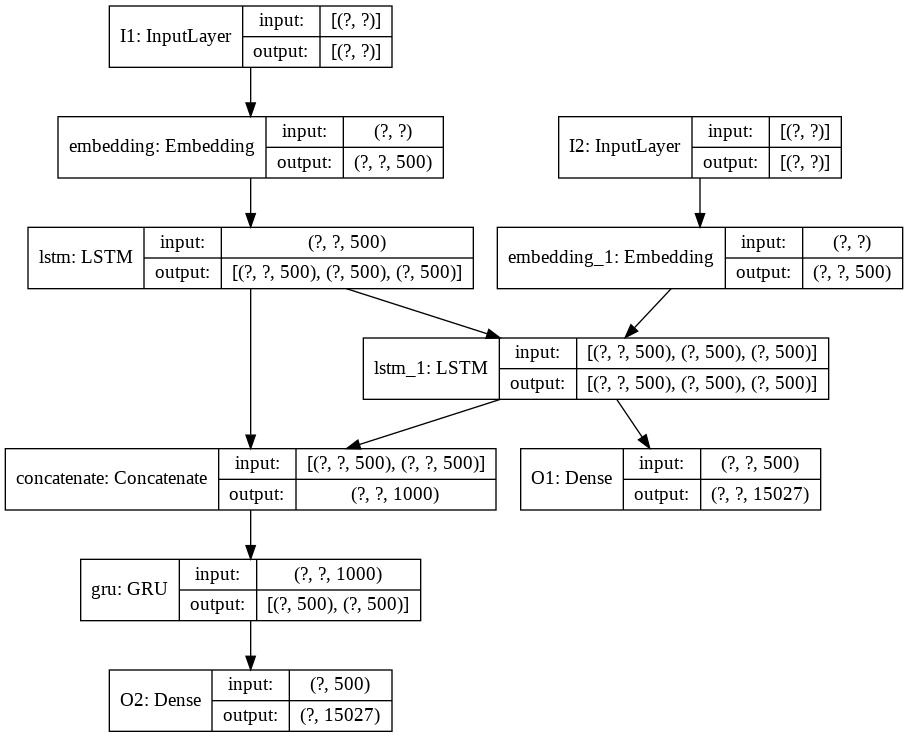

In [37]:
model.summary()

from keras.utils.vis_utils import plot_model
#model.load_weights('/content/drive/My Drive/nmt_weights.h5')
plot_model(model, to_file="dot_img_file.jpeg", show_shapes=True)

In [38]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 71
epochs = 10

In [39]:
def generate_batch(X = X_train, y = y_train, y1 = y1_train, y2 = y2_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            decoder_target_data1 = np.zeros((batch_size, num_encoder_tokens),dtype='float32')
            decoder_target_data2 = np.zeros((batch_size, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text, target_word1, target_word2) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size], y1[j:j+batch_size], y2[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        #print(i,t,decoder_input_data.shape,len(target_token_index),word)
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
                #print(y1_train[j][0])
                #print(y2_train,i,j)
                #print(i,j)
                #decoder_target_data1[i, y1_train[j][0]] = 1.
                if(target_word2 in target_token_index):
                  decoder_target_data2[i, target_token_index[target_word2]] = 1.
                else:
                  print(target_word2)
            yield([encoder_input_data, decoder_input_data], [decoder_target_data,decoder_target_data2])

In [ ]:
#print(X_train,y_train,y1_train,y2_train)
model.fit(generate_batch(X_train, y_train,y1_train,y2_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test,y1_test,y2_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)
# model.fit(
#     x={'I1':X_train, 'I2':x2}, y=(y_train,y1_train,y2_train), batch_size=batch_size, epochs=1, verbose=1, callbacks=None,
#     validation_split=0.2, validation_data=(X_test, (y_test,y1_test,y2_test)), shuffle=True, class_weight=None,
#     sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#     validation_steps=None, validation_batch_size=batch_size, validation_freq=1,
#     max_queue_size=10, workers=1, use_multiprocessing=False
#)
# obj = generate_batch(X_train, y_train,y1_train,y2_train, batch_size = batch_size)
# print(obj)

Epoch 1/10
102/102 [==============================] - 1241s 12s/step - loss: 10.5609 - O1_loss: 0.9171 - O2_loss: 9.6438 - val_loss: 10.4620 - val_O1_loss: 0.8373 - val_O2_loss: 9.6247
Epoch 2/10
102/102 [==============================] - 1274s 12s/step - loss: 9.6979 - O1_loss: 0.8243 - O2_loss: 8.8736 - val_loss: 11.1244 - val_O1_loss: 0.8203 - val_O2_loss: 10.3041
Epoch 3/10
 75/102 [=====================>........] - ETA: 5:16 - loss: 9.1688 - O1_loss: 0.7827 - O2_loss: 8.3861

In [ ]:
model.save_weights('/content/drive/My Drive/nmt_weights1.h5')

In [ ]:


# Below tensors will hold the states of the previous time step
encoder_state_input_h = Input(shape=(latent_dim,))
encoder_state_input_c = Input(shape=(latent_dim,))
encoder_states_inputs = [encoder_state_input_h, encoder_state_input_c]

enc_emb1 = enc_emb_layer(encoder_inputs)
encoder_outputs2, encoder_inputs_h, encoder_states_c = encoder_lstm(enc_emb1)
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs21, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs21) # A dense softmax layer to generate prob dist. over the target vocabulary

#print(decoder_outputs21.shape,encoder_outputs2.shape)
concad = Concatenate()([decoder_outputs21,encoder_outputs2])
seqr,cns = decoder_lstmd(concad)

decoder_outputs2r = decoder_dense1(seqr)

# Final decoder model
decoder_model = Model(
    [encoder_inputs,decoder_inputs] + decoder_states_inputs,[decoder_outputs2,decoder_outputs2r] + decoder_states2)


In [ ]:
train_gen = generate_batch(X_train, y_train,y1_train,y2_train, batch_size = 1)
k=-1


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
    input_seq = input_seq.reshape(max_length_src,1,1)
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    i =0;
    while not stop_condition:
        #print(i)
        obj = [target_seq] + states_value
        #print("dd",i,input_seq.shape,input_seq.shape,target_seq,target_seq.shape,states_value[0].shape,states_value[1].shape)
        outp  = decoder_model.predict([input_seq[i],target_seq] + states_value)
        #print(outp[3].shape)
        output_tokens, q,h, c = outp
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        qin = np.argmax(q)
        q = reverse_target_char_index[qin]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

        i=i+1;
    return decoded_sentence,q

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence,decoded_word = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print('Predicted Hindi Word:', decoded_word)

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence,decoded_word = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print('Predicted Hindi Word:', decoded_word)

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence,decoded_word = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print('Predicted Hindi Word:', decoded_word)

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence,decoded_word = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print('Predicted Hindi Word:', decoded_word)

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence,decoded_word = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print('Predicted Hindi Word:', decoded_word)